In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')

In [3]:
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

In [4]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

idx_filter_bid = df_raw['best_bid'] > 0.0
idx_filter_spread = \
    (df_raw['best_offer'] - df_raw['best_bid'] >= 0.0) & \
    (((df_raw['best_offer'] - df_raw['best_bid']) / (df_raw['best_bid'] + df_raw['best_offer'] ) * 2) <= 0.1) # this alone filters about 6%
idx_filter_impl_vol = ~ df_raw['impl_volatility'].isna()
idx_filter_leverage = df_raw['delta'].abs().between(*np.nanquantile(df_raw['delta'].abs(), [0.01, 0.99]))
idx_filter_no_trade_consistency = (df_raw['volume'] > 0) == (df_raw['date'] == df_raw['last_date']) # probably corrupted data, current count of only 86

df = df_raw[
    idx_filter_bid & 
    idx_filter_spread & 
    idx_filter_impl_vol & 
    idx_filter_leverage & 
    idx_filter_no_trade_consistency
]

print(f"Retained sample {df.shape[0] / df_raw.shape[0]:.2%}")

Retained sample 76.67%


## Auxiliary columns

In [5]:
df['ttm'] = (df['exdate'] - df['date']).dt.days
df['days_since_last'] = (df['date'] - df['last_date']).dt.days
df['traded'] = df['volume'] > 0

## Find actively trading options

In [6]:
df['consecutive_traded'] = df.groupby('symbol')['traded'].transform(
    lambda x: (x != x.shift(1)).cumsum()
)
df.loc[~df['traded'], 'consecutive_traded'] = np.nan

df['consecutive_traded_len'] = df.groupby(['symbol', 'consecutive_traded'])['traded'].transform('count')

In [7]:
def filter_consecutive_trading(df, consecutive_threshold):
    """
    Filter the DataFrame to include only rows where the options have been trading for at least n days consecutively.
    """
    consecutive_traded_start = df.loc[
        (df['traded']) &
        (df['consecutive_traded_len'] >= consecutive_threshold)]
    consecutive_traded_start = consecutive_traded_start.loc[
        (consecutive_traded_start.groupby('symbol').cumcount() == 0), 
        ['symbol', 'date']
    ].rename(columns={'date': 'consecutive_traded_start'})
    df_active = df.merge(
        consecutive_traded_start,
        how='left',
        on='symbol'
    )
    df_active = df_active[df_active['date'] >= df_active['consecutive_traded_start']]
    return df_active

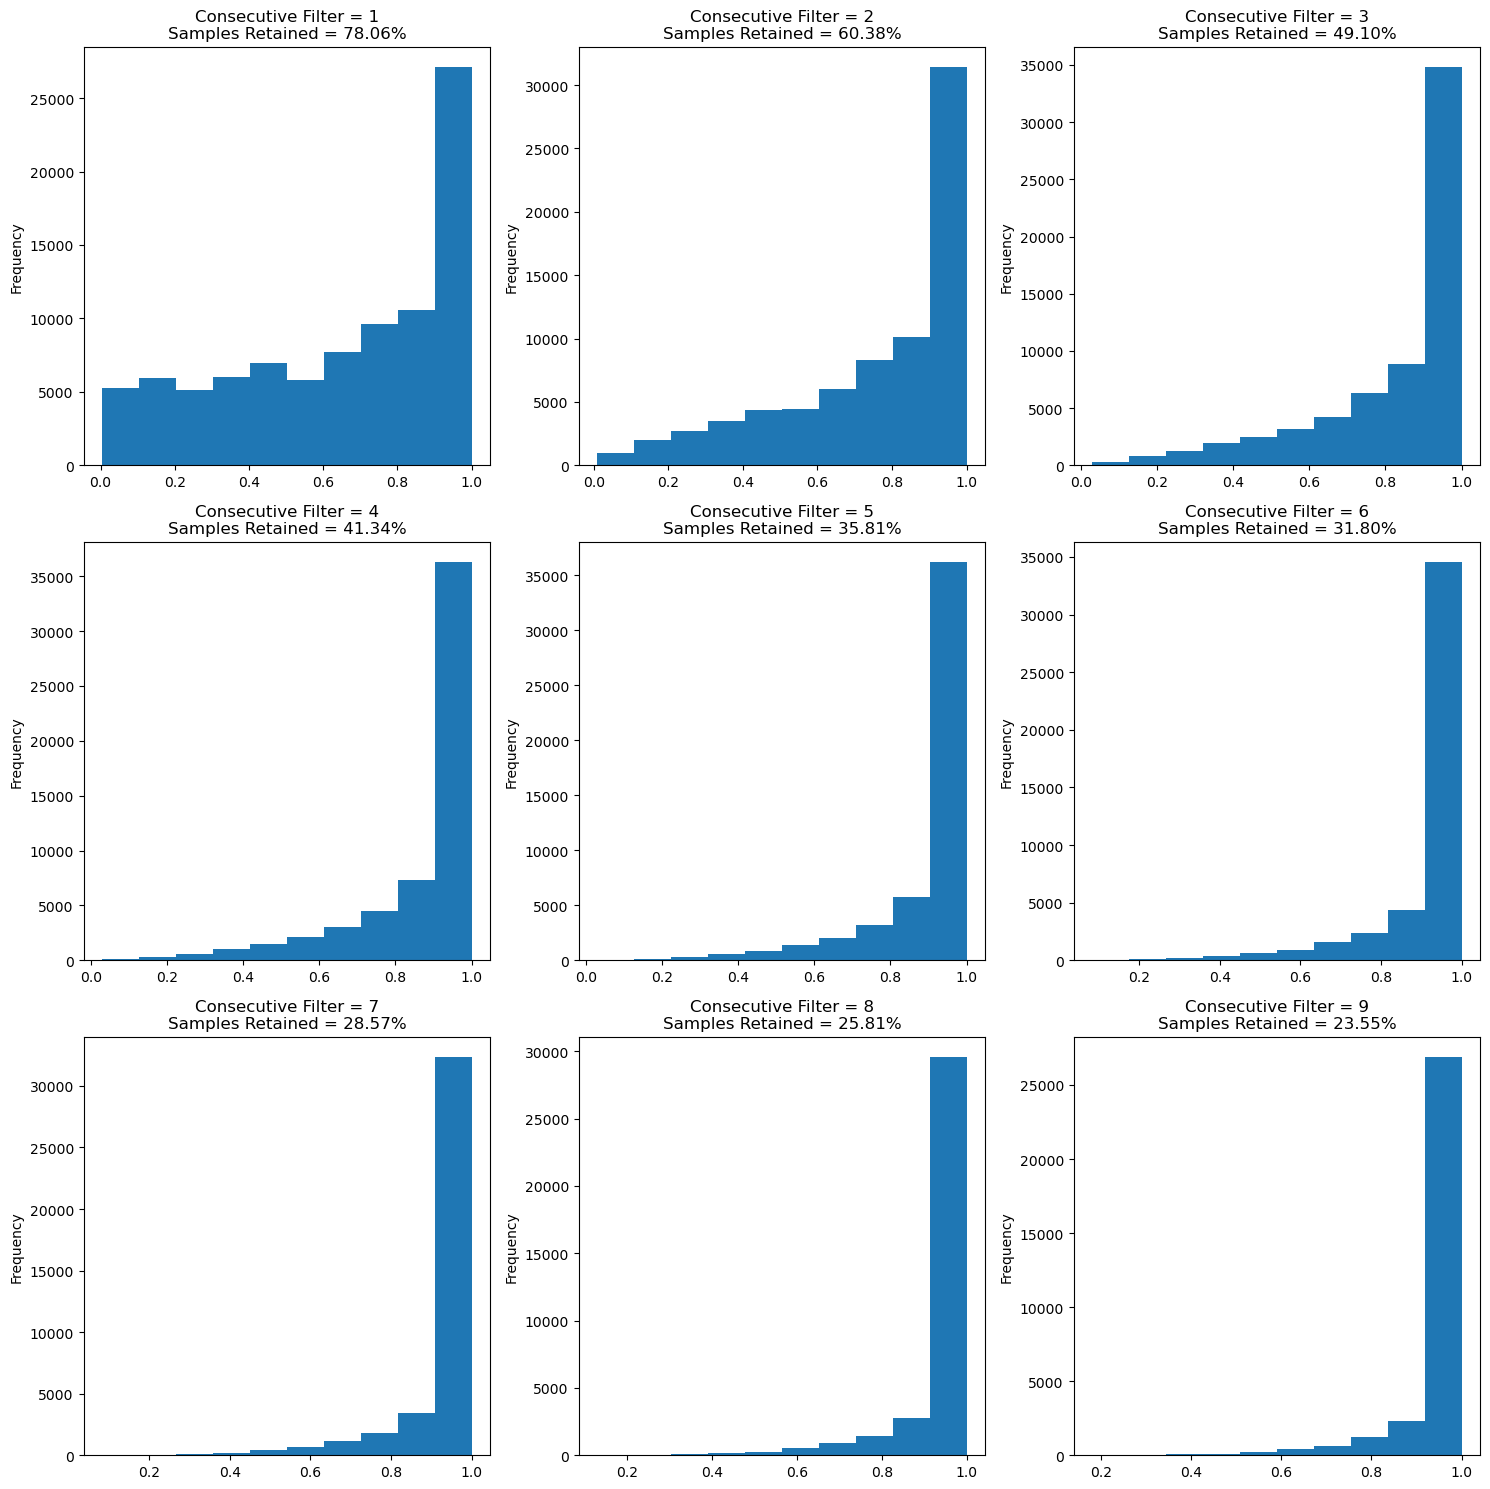

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes, start=1):
    consecutive_threshold = i
    df_active = filter_consecutive_trading(df, consecutive_threshold)
    trading_portion = (df_active['volume'] > 0).groupby(df_active['symbol']).mean()
    trading_portion.plot(kind='hist', ax=ax, bins=10)
    ax.set_title(f'Consecutive Filter = {consecutive_threshold}\nSamples Retained = {df_active.shape[0] / df.shape[0]:.2%}')

plt.tight_layout()

4 or 5 look like a reasonable choice. 

In [9]:
df_active = filter_consecutive_trading(df, consecutive_threshold=5)

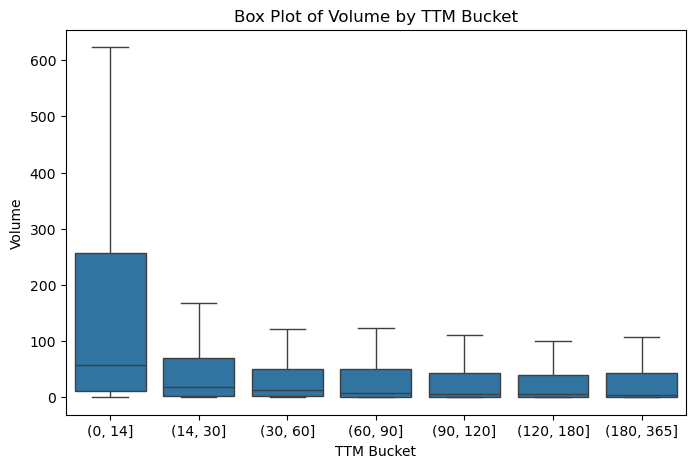

In [10]:
ttm_bins = np.array([0, 14, 30, 60, 90, 120, 180, 365])

# Add a column for delta buckets
df_plot = df_active.copy()
df_plot['ttm_bucket'] = pd.cut(df_active['ttm'], bins=ttm_bins)

# Create a box plot for volume in each delta bucket

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_plot, x='ttm_bucket', y='volume', showfliers=False)
plt.title('Box Plot of Volume by TTM Bucket')
plt.xlabel('TTM Bucket')
plt.ylabel('Volume')
plt.show()

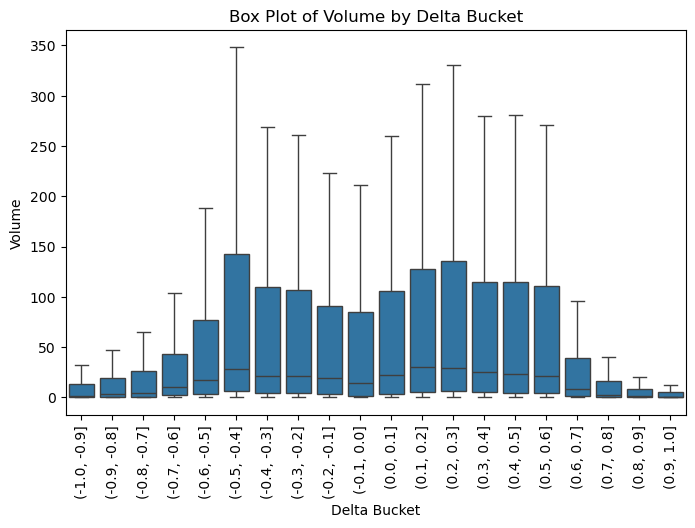

In [11]:
delta_bins = np.linspace(-1, 1, num=21)

# Add a column for delta buckets
df_plot = df_active.copy()
df_plot['delta_bucket'] = pd.cut(df_plot['delta'], bins=delta_bins)

# Create a box plot for volume in each delta bucket

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_plot, y='volume', x='delta_bucket', showfliers=False)
plt.xticks(rotation=90)
plt.title('Box Plot of Volume by Delta Bucket')
plt.xlabel('Delta Bucket')
plt.ylabel('Volume')
plt.show()

<Axes: xlabel='relative_spread', ylabel='volume'>

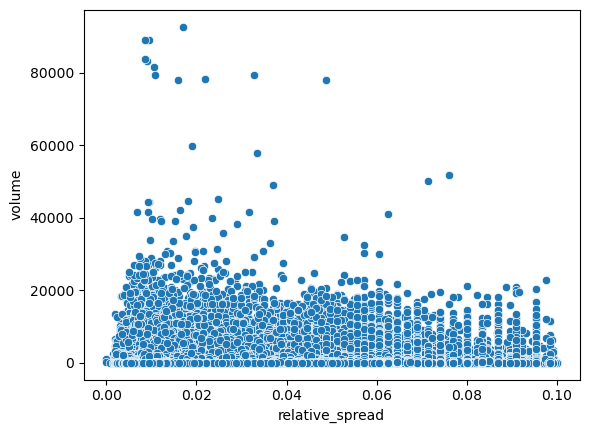

In [13]:
df_active['relative_spread'] = (df_active['best_offer'] - df_active['best_bid']) / (df_active['best_bid'] + df_active['best_offer'] ) * 2
sns.scatterplot(data=df_active, x='relative_spread', y='volume')

In [14]:
df_active.query('relative_spread == 1')

,date,symbol,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,ttm,days_since_last,traded,consecutive_traded,consecutive_traded_len,consecutive_traded_start,relative_spread
